# Zipfile 풀기

In [1]:
# import zipfile

# with zipfile.ZipFile('./Fashion_dataset.zip', 'r') as existing_zip:
#     existing_zip.extractall('./')

In [2]:
import numpy as np
np.random.seed(2022)
from tensorflow.random import set_seed
set_seed(2022)

In [3]:
import shutil
from collections import defaultdict
import json
from pathlib import Path
import os
import numpy as np
from glob import glob
import pandas as pd
from tqdm import tqdm

from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dropout,Flatten,Dense,Activation, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
tf.keras.backend.clear_session()
from tensorflow.keras.callbacks import CSVLogger
import time
from datetime import datetime

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [5]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()


In [6]:
images = glob('./fashion-dataset/images/*')
styles = pd.read_csv('./fashion-dataset/styles.csv', on_bad_lines='skip')

In [7]:
styles['baseColour'].value_counts().to_frame()

,baseColour
Black,9728
White,5538
Blue,4918
Brown,3494
Grey,2741
Red,2455
Green,2115
Pink,1860
Navy Blue,1789
Purple,1640


In [8]:
# # 400개 이상의 color만 사용
# colors = ['Beige', 'Black', 'Blue', 'Brown', 'Gold', 'Green', 'Grey', 'Maroon', 'Navy',
#           'Olive', 'Orange', 'Pink', 'Purple', 'Red', 'Silver', 'White', 'Yellow']

# color_dict = {color:index for index,color in enumerate(colors)}

# if not os.path.exists('./color_data'):
#     os.mkdir('./color_data')
# for c in colors:
#     if not os.path.exists(f'./color_data/{c}'):
#         os.mkdir(f'./color_data/{c}')

In [9]:
# for img in tqdm(images):
#     id = int(os.path.basename(img).split('.')[0])
#     color = styles.loc[styles['id'] == id]['baseColour'].to_string().split()[1]
#     if color not in colors:
#         continue
    
#     shutil.copy(img, f'./color_data/{color}/'+os.path.basename(img))

In [10]:
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/GPU:0","/GPU:1"])
# with mirrored_strategy.scope():
isize = 128
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet',input_shape=(isize, isize, 3), pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(17, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 129, 129, 3)  0           ['normalization[0][0]']      

In [12]:
data_gen = ImageDataGenerator(
    rescale=1/255.,              
    brightness_range=None,
    width_shift_range=0.5,
    rotation_range=False,
    horizontal_flip=True,
    vertical_flip=False,    
    validation_split=0.2
)

In [13]:
BATCH_SIZE = 256
traingen=data_gen.flow_from_directory(
    directory='./color_data',
    subset="training",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
    target_size=(isize, isize))

validgen=data_gen.flow_from_directory(
    directory='./color_data',
    subset="validation",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
    target_size=(isize, isize))

Found 32955 images belonging to 17 classes.
Found 8231 images belonging to 17 classes.


In [ ]:
t1 = time.time()/60

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE
n_epochs = 80

csv_logger = CSVLogger('fashion_training.log', separator=',', append=False)

checkpointer = ModelCheckpoint(filepath='fashion-EFN-model.best.h5', 
                               verbose=1, 
                               save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history = model.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, csv_logger],
                    verbose=True,
                    shuffle = True,
                    workers=4)

t2 = time.time()/60
print("Duration:", t2-t1)

Epoch 1/80
128/128 [==============================] - ETA: 0s - loss: 2.9560 - accuracy: 0.2284
Epoch 00001: val_loss improved from inf to 3.63222, saving model to fashion-EFN-model.best.h5


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


128/128 [==============================] - 271s 2s/step - loss: 2.9560 - accuracy: 0.2284 - val_loss: 3.6322 - val_accuracy: 0.0383
Epoch 2/80
128/128 [==============================] - ETA: 0s - loss: 1.9445 - accuracy: 0.4750
Epoch 00002: val_loss improved from 3.63222 to 3.47668, saving model to fashion-EFN-model.best.h5
128/128 [==============================] - 259s 2s/step - loss: 1.9445 - accuracy: 0.4750 - val_loss: 3.4767 - val_accuracy: 0.0641
Epoch 3/80
128/128 [==============================] - ETA: 0s - loss: 1.6293 - accuracy: 0.5437
Epoch 00003: val_loss improved from 3.47668 to 3.41511, saving model to fashion-EFN-model.best.h5
128/128 [==============================] - 254s 2s/step - loss: 1.6293 - accuracy: 0.5437 - val_loss: 3.4151 - val_accuracy: 0.1315
Epoch 4/80
128/128 [==============================] - ETA: 0s - loss: 1.4488 - accuracy: 0.5900
Epoch 00004: val_loss did not improve from 3.41511
128/128 [==============================] - 256s 2s/step - loss: 1.448

In [75]:
model.save("fashion_color.h5")

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


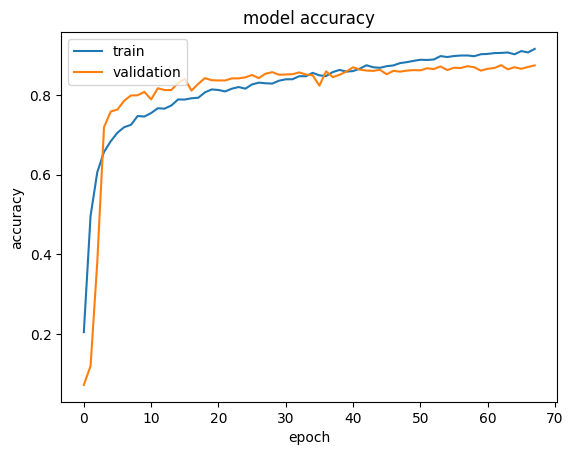

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Test

In [44]:
class_subset = sorted(os.listdir(test))

In [43]:
test_generator = ImageDataGenerator(rescale=1./255)

In [45]:
class_subset

['beige',
 'black',
 'blue',
 'brown',
 'gold',
 'green',
 'grey',
 'orange',
 'pink',
 'purple',
 'red',
 'silver',
 'tan',
 'white',
 'yellow']

In [46]:
testgen = test_generator.flow_from_directory(test,
                                               target_size=(isize, isize),
                                               batch_size=1,
                                               class_mode=None,
                                               classes=class_subset,
                                               shuffle=False
                                               )

Found 1556 images belonging to 15 classes.


In [47]:
model_predict = model.predict(testgen)

In [48]:
model_predict.shape

(1556, 15)

In [49]:
df_testprediction = pd.DataFrame(model_predict, index=testgen.filenames, columns=class_subset)

In [50]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
df_testprediction

,beige,black,blue,brown,gold,green,grey,orange,pink,purple,red,silver,tan,white,yellow
beige/02e37c0e56.jpg,0.4828,0.0008,0.0007,0.1199,0.0015,0.0006,0.0271,0.0001,0.0002,0.0001,0.0077,0.0043,0.3538,0.0001,0.0001
beige/05aeb6ddec.jpg,0.4039,0.0004,0.0002,0.1125,0.0004,0.0000,0.0111,0.0000,0.0000,0.0000,0.0000,0.0003,0.4709,0.0001,0.0000
beige/0b01008bee.jpg,0.7761,0.0002,0.0005,0.0014,0.0056,0.0009,0.0006,0.0001,0.0010,0.0011,0.0005,0.0093,0.1997,0.0027,0.0003
beige/0c3bb456ee.jpg,0.2017,0.0027,0.0054,0.0284,0.1539,0.0021,0.0040,0.0056,0.0025,0.0090,0.0098,0.0311,0.5060,0.0287,0.0091
beige/0e491569c8.jpg,0.1887,0.0002,0.0000,0.0394,0.0021,0.0000,0.0010,0.0000,0.0004,0.0000,0.0000,0.0002,0.7679,0.0001,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yellow/fd1da2f797.jpg,0.0000,0.0000,0.0000,0.0003,0.0048,0.0000,0.0000,0.0024,0.0001,0.0000,0.0000,0.0000,0.0002,0.0001,0.9921
yellow/fd3d2525fb.jpg,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0010,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.9985
yellow/feacf53e9e.jpg,0.0006,0.0000,0.0010,0.0011,0.1053,0.0098,0.0002,0.0010,0.0001,0.0002,0.0003,0.0002,0.0030,0.0004,0.8768
yellow/feeded3e6e.jpg,0.0000,0.0000,0.0000,0.0000,0.9959,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0040


In [51]:
predicted_classes = np.argmax(model.predict(testgen), axis=-1) #model.predict_classes(testgen). Argmax returns indices of max values
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

In [52]:
len(predicted_classes)

1556

In [53]:
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]), color=("green" if pred_idx == true_idx else "red"))
    fig.savefig('testgallery.png')

In [54]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 84.19%


,Precision,Recall,F-Score,Support
blue,0.9684,0.9623,0.9653,159.0000
purple,0.9735,0.9565,0.9649,115.0000
green,0.9667,0.9587,0.9627,121.0000
yellow,0.9664,0.9274,0.9465,124.0000
pink,0.9485,0.8932,0.9200,103.0000
orange,0.9130,0.9211,0.9170,114.0000
red,0.8873,0.9265,0.9065,136.0000
black,0.8764,0.8966,0.8864,87.0000
white,0.8370,0.8953,0.8652,86.0000
brown,0.8240,0.8512,0.8374,121.0000


In [55]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [56]:
pd.DataFrame(confusion_matrix(true_classes, predicted_classes), index=list(class_indices.values()), columns=list(class_indices.values()) )

,beige,black,blue,brown,gold,green,grey,orange,pink,purple,red,silver,tan,white,yellow
beige,43,1,0,3,0,0,0,0,0,0,0,2,41,0,0
black,0,78,0,2,0,0,7,0,0,0,0,0,0,0,0
blue,1,0,153,0,0,1,2,0,0,2,0,0,0,0,0
brown,6,2,0,103,4,0,1,1,0,0,0,0,3,1,0
gold,2,2,0,4,26,0,0,0,2,0,0,0,6,0,3
green,0,0,2,0,0,116,1,0,0,0,1,0,1,0,0
grey,1,3,1,5,0,1,66,0,0,0,0,11,2,2,0
orange,0,0,0,3,0,0,0,105,0,0,5,0,0,0,1
pink,0,0,0,0,0,0,0,0,92,1,10,0,0,0,0
purple,0,1,2,1,0,0,0,0,1,110,0,0,0,0,0


In [58]:
from sklearn.metrics import *
print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.51      0.48      0.49        90
           1       0.88      0.90      0.89        87
           2       0.97      0.96      0.97       159
           3       0.82      0.85      0.84       121
           4       0.72      0.58      0.64        45
           5       0.97      0.96      0.96       121
           6       0.75      0.72      0.73        92
           7       0.91      0.92      0.92       114
           8       0.95      0.89      0.92       103
           9       0.97      0.96      0.96       115
          10       0.89      0.93      0.91       136
          11       0.71      0.66      0.68        77
          12       0.46      0.57      0.51        86
          13       0.84      0.90      0.87        86
          14       0.97      0.93      0.95       124

    accuracy                           0.84      1556
   macro avg       0.82      0.81      0.82      1556
weighted avg       0.85   

## Predict

In [60]:
def color_tag(sourcedir, imin, isize, thr):
    """
    Displays dominant colors beyond a given threshold.
    sourcedir: directory where image can be found, for ex.: '/home/administrateur/Documents/RR/colors/fashion-train/purple'
    imin : image input, for ex 'blue-car.jpg'
    isize: input image size, for ex. 224
    thr: chosen threshold value
    """
    
    image = tf.keras.preprocessing.image.load_img(os.path.join(sourcedir, imin), target_size=(isize, isize))
    data = asarray(image)
    ndata = np.expand_dims(data, axis=0)
    y_prob = model.predict(ndata/255)
    y_prob.argmax(axis=-1)
    
    print('color', [sorted(os.listdir(train))[i] for i in np.where(np.ravel(y_prob)>thr)[0]])
    print('values', [np.ravel(y_prob)[i] for i in list(np.where(np.ravel(y_prob)>thr)[0])])

In [64]:
inference = './myntradataset/images'

test 1

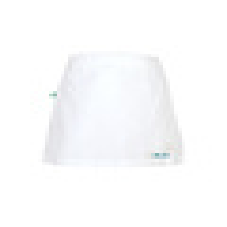

In [65]:
tf.keras.preprocessing.image.load_img(os.path.join(inference, '10000.jpg'), target_size=(227, 227))

In [66]:
color_tag(inference, '10000.jpg', isize, 0.1)

color ['black', 'brown']
values [0.7295403, 0.119818404]


test 2

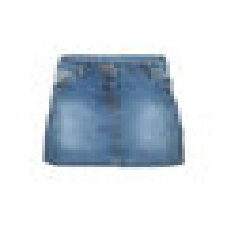

In [67]:
tf.keras.preprocessing.image.load_img(os.path.join(inference, '10001.jpg'), target_size=(227, 227))

In [68]:
color_tag(inference, '10001.jpg', isize, 0.1)

color ['black', 'brown', 'grey']
values [0.106411465, 0.15326594, 0.5624624]


test 3

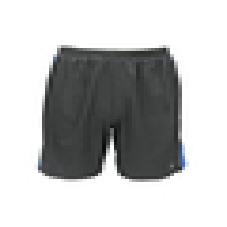

In [69]:
tf.keras.preprocessing.image.load_img(os.path.join(inference, '10004.jpg'), target_size=(227, 227))

In [70]:
color_tag(inference, '10004.jpg', isize, 0.1)

color ['black', 'grey']
values [0.6905917, 0.19916752]


test 4

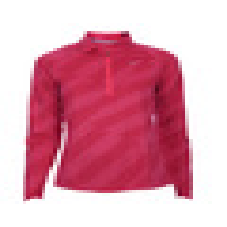

In [71]:
tf.keras.preprocessing.image.load_img(os.path.join(inference, '10025.jpg'), target_size=(227, 227))

In [72]:
color_tag(inference, '10025.jpg', isize, 0.1)

color ['black', 'pink', 'red']
values [0.15469946, 0.28265178, 0.2923002]


test 5

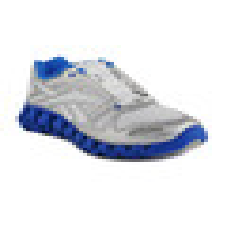

In [73]:
tf.keras.preprocessing.image.load_img(os.path.join(inference, '10081.jpg'), target_size=(227, 227))

In [74]:
color_tag(inference, '10081.jpg', isize, 0.1)

color ['beige', 'black', 'brown', 'grey', 'tan']
values [0.117771186, 0.18809666, 0.1523966, 0.2409978, 0.107092835]
